In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


####Downloading the dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [3]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [4]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [5]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [6]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [47]:
class VAE(nn.Module):
    def __init__(self, learned_covariance=False, gamma=0.1):
        super(VAE, self).__init__()
        self.learned_covariance = learned_covariance
        self.gamma = 0.1

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma
        self.fccm = nn.Linear(128, 8*8) # Sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        if not self.learned_covariance:
            return self.fc21(h), self.fc22(h) # mu, std
        else:
            sigma = self.fccm(h).reshape(-1, 8,8)
            return self.fc21(h), sigma
    
    def sampling(self, mu, sigma): # Reparameterization trick
        if not self.learned_covariance:
            eps1 = torch.randn_like(sigma)
            eps2 = torch.randn_like(sigma)
            return 0.5*((eps1 * sigma + mu) + (eps2 * sigma + mu)) # Using two samples to compute expectation over z
        else:
            cov = sigma.transpose(1,2) @ sigma 
            cov += self.gamma * torch.eye(sigma.shape[-1]).to(sigma.device)
            mvn = torch.distributions.MultivariateNormal(mu, cov)
            eps = mvn.sample()
            return mu + eps
            
    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, sigma = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, sigma)
        return self.decoder(z), mu, sigma

    def loss_function(self, y, x, mu, std): 
        ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    
        # Handle covariance matrix case
        if std.dim() == 3:  # If std is a batch of covariance matrices (B, D, D)
            B, D, _ = std.shape
            cov = std.transpose(1,2) @ std 
            cov += self.gamma * torch.eye(std.shape[-1]).to(std.device)
            identity = torch.eye(D, device=std.device).expand(B, D, D)  # Identity matrix
            log_det_cov = torch.logdet(cov + 1e-6 * identity)  # Small epsilon for numerical stability
            trace_cov = torch.einsum('bii->b', cov)  # Sum over diagonal elements
            KLD = -0.5 * torch.sum(1 + log_det_cov - trace_cov - torch.sum(mu**2, dim=-1))    
        else:  # If std is a standard deviation vector (B, D)
            KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)

        return ERR + KLD, -ERR, -KLD


### Defining loss, optimizer and LR scheduler

### Training and Validating

In [49]:
import torch
import torch.nn.functional as F

def train_model(model, 
                trainloader,
                testloader,
                optimizer, 
                scheduler, 
                num_epochs=20, 
                device="cuda"):
    """
    Train a given model using a variational autoencoder (VAE) training loop.
    
    Parameters:
    - model: The neural network model to train.
    - trainloader: DataLoader for training data.
    - testloader: DataLoader for test/validation data.
    - optimizer: Optimizer (e.g., Adam, SGD).
    - scheduler: Learning rate scheduler.
    - loss_function: Loss function for training (should handle both std as vector and matrix).
    - num_epochs: Number of training epochs.
    - device: "cuda" or "cpu".
    
    Returns:
    - err_l, kld_l, n_wu, testl, update: Lists tracking training progress.
    """
    model.to(device)
    err_l, kld_l, n_wu, testl, update = [], [], [], [], []
    count = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0

        for batch_idx, (data, _) in enumerate(trainloader):
            data = data.to(device)
            bsize = data.shape[0]

            # Forward pass
            recon_batch, mu, std = model(data)

            # Compute loss
            loss, err, kld = model.loss_function(recon_batch, data, mu, std)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += err.item() + kld.item()
            err_l.append(err.item() / bsize)
            kld_l.append(kld.item() / bsize)
            count += 1
            n_wu.append(count)

            # Validation every 100 updates
            if count % 100 == 0:
                model.eval()
                with torch.no_grad():
                    a, _ = next(iter(testloader))
                    a = a.to(device)
                    trecon, tmu, tstd = model(a)
                    tloss, terr, tkld = model.loss_function(trecon, a, tmu, tstd)
                    testl.append(terr.item() / 100)
                    update.append(count)

        # Adjust learning rate
        scheduler.step(train_loss / len(trainloader.dataset))

        # Print training progress
        avg_train_loss = train_loss / len(trainloader.dataset)
        print(f"====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}")

        # Evaluate on the test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in testloader:
                data = data.to(device)
                recon, mu, std = model(data)
                loss, err, kld = model.loss_function(recon, data, mu, std)
                test_loss += err + kld
        
        test_loss /= len(testloader.dataset)
        print(f"====> Test set loss: {test_loss:.4f}")

    return err_l, kld_l, n_wu, testl, update


In [57]:
model = VAE()
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

vae_ret = train_model(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = vae_ret

====> Epoch: 1 Average loss: -53.2677
====> Test set loss: -42.7890
====> Epoch: 2 Average loss: -40.3786
====> Test set loss: -38.2030
====> Epoch: 3 Average loss: -37.5627
====> Test set loss: -36.8357
====> Epoch: 4 Average loss: -36.4730
====> Test set loss: -36.1491
====> Epoch: 5 Average loss: -35.8613
====> Test set loss: -35.6973
====> Epoch: 6 Average loss: -35.2997
====> Test set loss: -35.0855
====> Epoch: 7 Average loss: -34.8754
====> Test set loss: -34.6909
====> Epoch: 8 Average loss: -34.4454
====> Test set loss: -34.5970
====> Epoch: 9 Average loss: -34.1073
====> Test set loss: -34.1465
====> Epoch: 10 Average loss: -33.8704
====> Test set loss: -34.2046
====> Epoch: 11 Average loss: -33.5732
====> Test set loss: -33.7378
====> Epoch: 12 Average loss: -33.3849
====> Test set loss: -33.4733
====> Epoch: 13 Average loss: -33.1960
====> Test set loss: -33.4362
====> Epoch: 14 Average loss: -33.0608
====> Test set loss: -33.3464
====> Epoch: 15 Average loss: -32.9086
====

In [61]:
cv_model = VAE(learned_covariance=True, gamma=1.0)
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
optimizer = torch.optim.Adam(cv_model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

cv_ret = train_model(
    model=cv_model,
    trainloader=trainloader,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device="cuda"
)

err_l, kld_l, n_wu, testl, update = cv_ret

====> Epoch: 1 Average loss: -52.8853
====> Test set loss: -45.0785
====> Epoch: 2 Average loss: -43.5004
====> Test set loss: -41.9203
====> Epoch: 3 Average loss: -41.3445
====> Test set loss: -40.4064
====> Epoch: 4 Average loss: -40.3059
====> Test set loss: -39.9298
====> Epoch: 5 Average loss: -39.6903
====> Test set loss: -39.6286
====> Epoch: 6 Average loss: -39.2550
====> Test set loss: -39.3124
====> Epoch: 7 Average loss: -39.0081
====> Test set loss: -38.8884
====> Epoch: 8 Average loss: -38.7142
====> Test set loss: -38.4830
====> Epoch: 9 Average loss: -38.6006
====> Test set loss: -38.7423
====> Epoch: 10 Average loss: -38.3808
====> Test set loss: -38.6078
====> Epoch: 11 Average loss: -38.2383
====> Test set loss: -37.9520
====> Epoch: 12 Average loss: -38.0249
====> Test set loss: -38.0338
====> Epoch: 13 Average loss: -38.0255
====> Test set loss: -37.9933
====> Epoch: 14 Average loss: -37.8726
====> Test set loss: -38.2870
====> Epoch: 15 Average loss: -37.8064
====

### (iii) Plotting the first and second term of ELBO as a function of weight updates

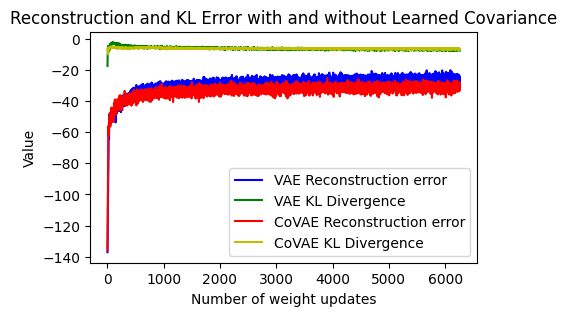

In [62]:
def plot_recon_and_kl_error(model_1_ret, model_2_ret):
    err_l_1, kld_l_1, n_wu_1, _, _ = model_1_ret
    err_l_2, kld_l_2, n_wu_2, _, _ = model_2_ret
    plt.figure(figsize=(5,3), dpi=100)
    plt.plot(n_wu_1, err_l_1, 'b', label='VAE Reconstruction error')
    plt.plot(n_wu_1, kld_l_1, 'g', label='VAE KL Divergence')
    plt.plot(n_wu_2, err_l_2, 'r', label='CoVAE Reconstruction error')
    plt.plot(n_wu_2, kld_l_2, 'y', label='CoVAE KL Divergence')
    plt.title('Reconstruction and KL Error with and without Learned Covariance')
    plt.xlabel('Number of weight updates')
    plt.ylabel('Value')
    plt.legend()

plot_recon_and_kl_error(vae_ret, cv_ret)

### (iv) 
### Visualizing input and output from the VAE from training set

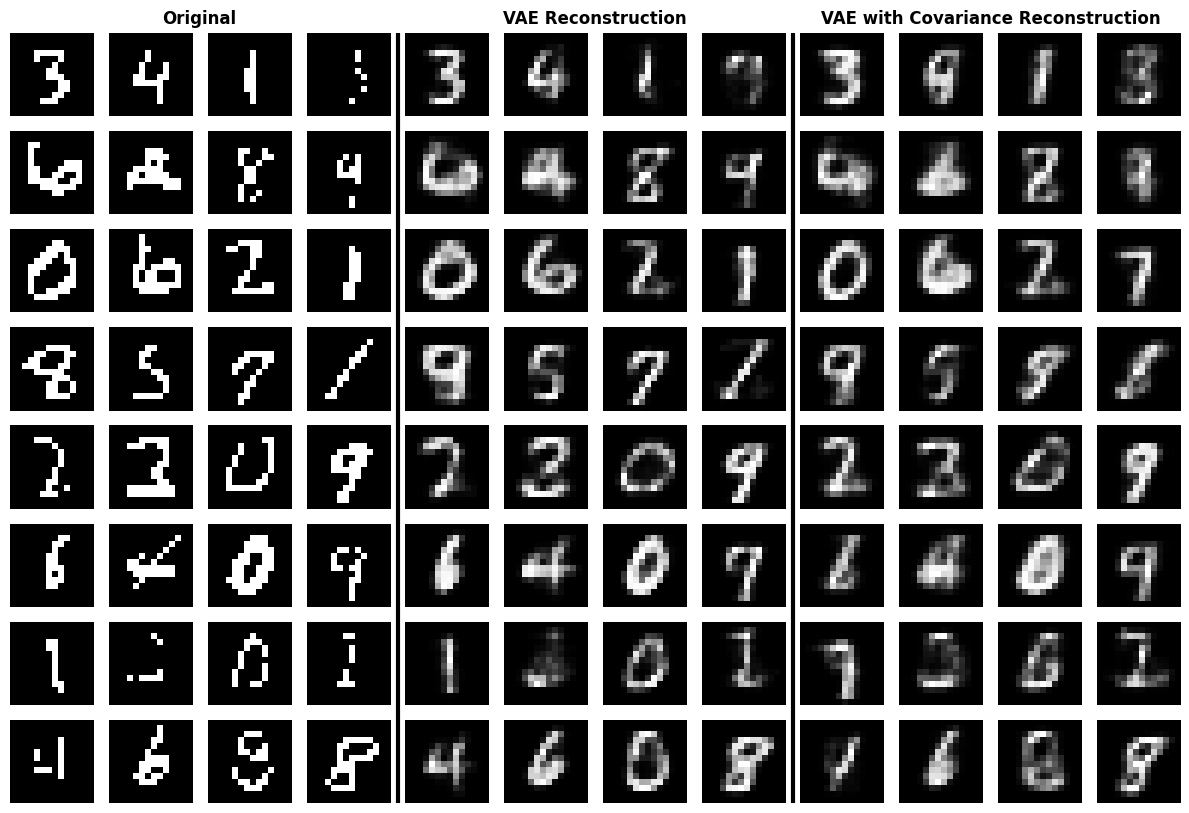

In [63]:
def compare_models(model1, model2, dataloader, device="cuda"):
    """
    Compares two models by reconstructing images and displaying results in an 8x12 grid.
    
    Parameters:
    - model1: First trained model.
    - model2: Second trained model.
    - dataloader: DataLoader for sampling images.
    - device: "cuda" or "cpu".
    
    Outputs:
    - Displays an 8x12 grid:
        - First 8x4: Original images
        - Second 8x4: Model 1 reconstructions (reshaped to 14x14)
        - Third 8x4: Model 2 reconstructions (reshaped to 14x14)
    """
    model1.eval()
    model2.eval()

    fig, axes = plt.subplots(8, 12, figsize=(12, 8))  # 8 rows, 12 columns

    with torch.no_grad():
        for i in range(8):
            # Get a batch of images
            a, _ = next(iter(dataloader))
            a = a.to(device)

            for j in range(4):  # Get 4 images per row
                img = a[j]
                recon1, _, _ = model1(img.unsqueeze(0))  # Add batch dim
                recon2, _, _ = model2(img.unsqueeze(0))

                # Convert tensors to NumPy arrays for plotting
                original = img.detach().cpu().numpy().squeeze()
                recon1 = recon1[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon2 = recon2[0].detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14

                # First section: Original images (8x4)
                axes[i, j].imshow(original, cmap="gray")
                
                # Second section: Model 1 reconstructions (8x4)
                axes[i, j + 4].imshow(recon1, cmap="gray")

                # Third section: Model 2 reconstructions (8x4)
                axes[i, j + 8].imshow(recon2, cmap="gray")

                # Remove axes for clean visualization
                for col in range(12):
                    axes[i, col].axis("off")

    fig.add_subplot(111, frameon=False)  # Invisible axis for lines
    plt.plot([.336, .336], [0, 1], color='black', lw=3, transform=fig.transFigure)
    plt.plot([.665, .665], [0, 1], color='black', lw=3, transform=fig.transFigure)

    plt.gca().set_xticks([])  # Remove x ticks
    plt.gca().set_yticks([])  # Remove y ticks

    # Add headers for each section
    fig.text(0.17, 1.0, 'Original', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(0.5, 1.0, 'VAE Reconstruction', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(0.83, 1.0, 'VAE with Covariance Reconstruction', ha='center', va='center', fontsize=12, fontweight='bold')


    plt.tight_layout()
    plt.show()

compare_models(model, cv_model, trainloader, device="cuda")

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

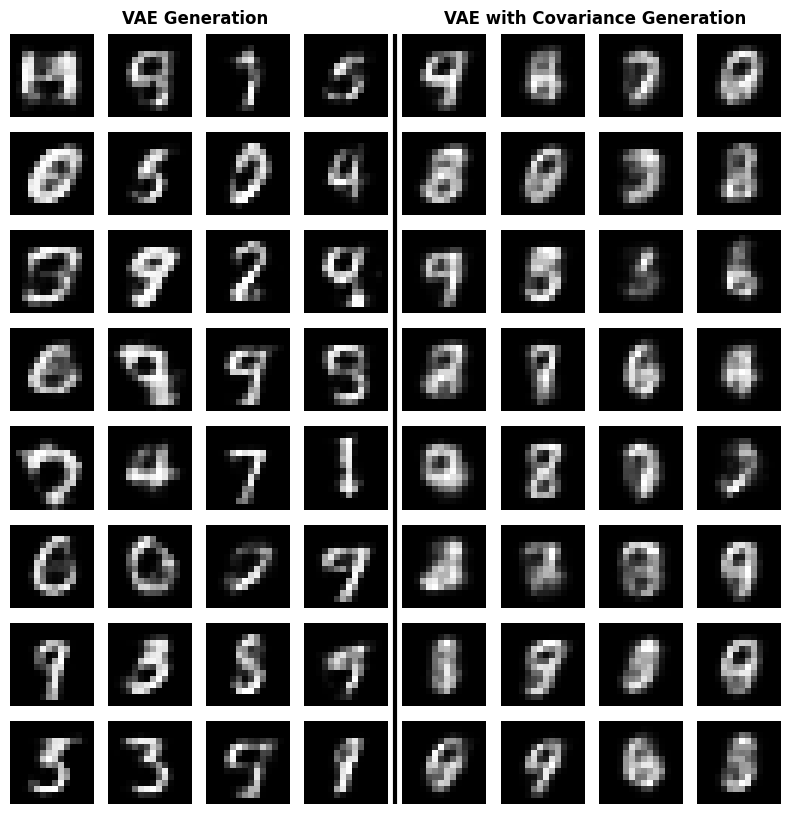

In [64]:
def generate_images(model1, model2, dataloader, device="cuda"):
    """
    Compares two models by reconstructing images and displaying results in an 8x12 grid.
    
    Parameters:
    - model1: First trained model.
    - model2: Second trained model.
    - dataloader: DataLoader for sampling images.
    - device: "cuda" or "cpu".
    
    Outputs:
    - Displays an 8x8 grid:
        - 1st 8x4: Model 1 reconstructions (reshaped to 14x14)
        - 2nd 8x4: Model 2 reconstructions (reshaped to 14x14)
    """
    model1.eval()
    model2.eval()

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))  # 8 rows, 12 columns

    with torch.no_grad():
        for i in range(8):
            for j in range(4):  # Get 4 images per row
                x = np.random.normal(0,1, 8)
                x= x.astype(np.float32)
                x=torch.from_numpy(x)
                x= x.cuda()
                recon1 = model1.decoder(x) # Add batch dim
                recon2 = model2.decoder(x)

                # Convert tensors to NumPy arrays for plotting
                recon1 = recon1.detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                recon2 = recon2.detach().cpu().numpy().reshape(14, 14)  # Reshape to 14x14
                
                # Second section: Model 1 reconstructions (8x4)
                axes[i, j].imshow(recon1, cmap="gray")

                # Third section: Model 2 reconstructions (8x4)
                axes[i, j + 4].imshow(recon2, cmap="gray")

                # Remove axes for clean visualization
                for col in range(8):
                    axes[i, col].axis("off")

    fig.add_subplot(111, frameon=False)  # Invisible axis for lines
    plt.plot([.5, .5], [0, 1], color='black', lw=3, transform=fig.transFigure)

    plt.gca().set_xticks([])  # Remove x ticks
    plt.gca().set_yticks([])  # Remove y ticks

    # Add headers for each section
    fig.text(0.25, 1.0, 'VAE Generation', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(0.75, 1.0, 'VAE with Covariance Generation', ha='center', va='center', fontsize=12, fontweight='bold')


    plt.tight_layout()
    plt.show()

generate_images(model, cv_model, trainloader, device="cuda")

### (vi)
### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

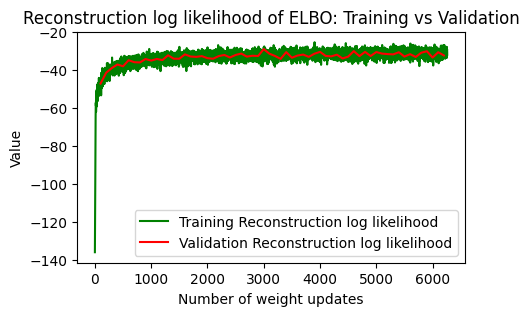

In [65]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()